## Testing PCM regression 


In [100]:
# Import necessary libraries
import PcmPy as pcm
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import exp, sqrt
from sklearn.linear_model import Ridge, LinearRegression

In [101]:
# Read in test data
f = open('/Users/jdiedrichsen/Python/PcmPy/demos/data_regression_test.p','rb')
Z,Y,U,comp = pickle.load(f)
f.close()

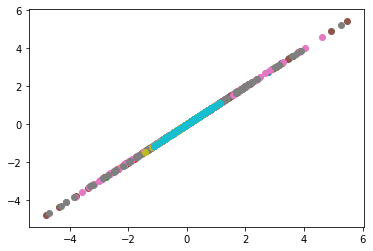

In [83]:
# Build the datasets from the Data and condition vectors 
M1 = pcm.regression.RidgeDiag(comp, fit_intercept = False)
M1.optimize_regularization(Z,Y)
M1.fit(Z,Y)
Y1 = M1.predict(Z)

M2 = Ridge(alpha=1,fit_intercept=False)
M2.fit(Z,Y)
Y2 = M2.predict(Z)

for i in range(10):
    plt.scatter(M1.coef_[i,:],M2.coef_[:,i])

In [105]:
# Check if it matches simulation 
def do_sim(): 
    num_sim = 10
    N = 50 
    Q = 10 
    P = 100 
    comp  = np.array([0, 0, 0, 0, 0, 1, 1, 1, 2, 2])
    theta = np.array([0, 1, -1, 3])
    s = sqrt(exp(theta[comp]))
    z = np.zeros((num_sim,))
    T = pd.DataFrame({'theta0':z,'theta1':z,'theta2':z,'theta3':z,'R2_Pcm':z,'R2_Lin':z,'R2_Rid':z})
    
    M = pcm.regression.RidgeDiag(comp, fit_intercept = False)
    R = Ridge(alpha=30.0, fit_intercept=False)
    L = LinearRegression(fit_intercept=False)
    for i in range(num_sim):
        # Make training data 
        U = np.random.normal(0,1,(Q,P))
        U = U * s.reshape((10,1)) 
        Z = np.random.normal(0,1,(N,Q))
        Y = Z @ U + np.random.normal(0,sqrt(exp(theta[-1])),(N,P))

        # Make test data 
        Zt = np.random.normal(0,1,(N,Q))
        Yt = Zt @ U + np.random.normal(0,1,(N,P))

        # PCM regression 
        M.optimize_regularization(Z,Y)
        M.fit(Z,Y)
        Yp = M.predict(Zt)
        T['theta0'][i]=M.theta_[0]
        T['theta1'][i]=M.theta_[1]
        T['theta2'][i]=M.theta_[2]
        T['theta3'][i]=M.theta_[3]
        T['R2_Pcm'][i]=1-np.sum((Yt-Yp)**2)/np.sum(Yt**2)
        
        # Linear regression 
        L.fit(Z,Y)
        Yp2 = L.predict(Zt)
        T['R2_Lin'][i]=1-np.sum((Yt-Yp2)**2)/np.sum(Yt**2)
        
        # Ridge regression 
        R.fit(Z,Y)
        Yp3 = R.predict(Zt)
        T['R2_Rid'][i]=1-np.sum((Yt-Yp3)**2)/np.sum(Yt**2)
             
    return T

In [106]:
D = do_sim()

In [107]:
D

,theta0,theta1,theta2,theta3,R2_Pcm,R2_Lin,R2_Rid
0,-0.248057,0.909809,-0.823480,2.987982,0.714155,0.585556,0.642959
1,0.095077,1.066007,-0.990509,3.032633,0.728655,0.584875,0.682529
2,-0.021753,1.035036,-0.871028,2.998863,0.723329,0.608224,0.657661
3,-0.072333,0.919452,-0.931713,3.023602,0.714178,0.601487,0.665801
4,0.065190,1.008968,-1.235310,2.966619,0.719087,0.610415,0.672717
5,0.038575,0.994412,-0.637505,2.998664,0.706565,0.543998,0.658617
6,-0.002492,1.194050,-1.011008,2.934932,0.753169,0.640936,0.704127
7,-0.034621,1.125260,-1.431150,3.036650,0.703853,0.553900,0.658823
8,-0.092072,1.030465,-1.581931,3.023872,0.715702,0.621461,0.667764
9,-0.121352,1.056770,-1.134272,3.018542,0.684948,0.521066,0.646191


In [95]:
theta[-1]

3

In [8]:
# Fit the model in to the full group, using a individual scaling parameter for each 
T_gr, theta = pcm.inference.fit_model_group(Y, M, fit_scale=True)


Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4


In [9]:
# crossvalidated likelihood is the same as the group fit for all 
# except the component and noise ceiling model
T_cv, theta_cv = pcm.inference.fit_model_group_crossval(Y, M, fit_scale=True)


Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4


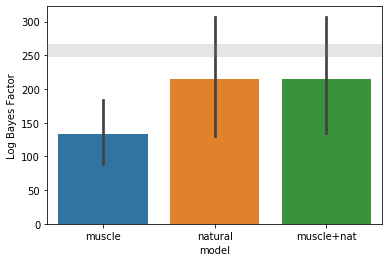

In [10]:
ax = pcm.vis.model_plot(T_cv.likelihood,null_model = 'null',noise_ceiling= 'ceil',upper_ceiling = T_gr.likelihood['ceil'])


In [10]:
T_gr

variable    likelihood                                            \
model             null        muscle       natural    muscle+nat   
0        -42231.412711 -41966.470799 -41786.672956 -41786.672945   
1        -34965.171104 -34923.791342 -34915.406608 -34915.406214   
2        -34767.538097 -34679.107626 -34632.643241 -34632.643003   
3        -45697.970627 -45609.052395 -45448.518276 -45448.518460   
4        -31993.363827 -31866.288313 -31806.982719 -31806.982541   
5        -41817.234010 -41632.061473 -41543.438786 -41543.438798   
6        -50336.142592 -50201.799362 -50173.300358 -50173.300312   

variable                   noise                                           \
model             ceil      null    muscle   natural muscle+nat      ceil   
0        -41729.668880  0.875853  0.871286  0.868482   0.868482  0.874193   
1        -34908.744214  1.070401  1.067480  1.069075   1.069075  1.073005   
2        -34607.535979  1.026408  1.021219  1.019122   1.019123  1.022025   
3        -45344.074725  1.480699  1.479592  1.474026   1.474026  1.479776   
4        -31738.538552  0.808482  0.805621  0.805774   0.805774  0.808484   
5        -41456.459249  1.035696  1.031827  1.031649   1.031649  1.036328   
6        -50157.026613  1.479001  1.472401  1.474430   1.474430  1.481835   

variable     scale                                          iterations         \
model         null    muscle   natural muscle+nat      ceil       null muscle   
0         0.109319  0.750145  0.786771   1.209841  1.135093         13      4   
1         0.045008  0.324407  0.322917   0.496560  0.436238         13      4   
2         0.059863  0.435483  0.463987   0.713478  0.664386         13      4   
3         0.173031  1.193770  1.235628   1.900067  1.758033         13      4   
4         0.073935  0.516338  0.532421   0.818724  0.764043         13      4   
5         0.116696  0.801114  0.828773   1.274435  1.185213         13      4   
6         0.101477  0.714043  0.723969   1.113272  1.002238         13      4   

variable                          
model    natural muscle+nat ceil  
0              4          6   26  
1              4          6   26  
2              4          6   26  
3              4          6   26  
4              4          6   26  
5              4          6   26  
6              4          6   26

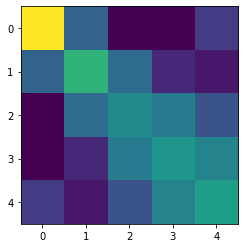

In [23]:
G,_ = M[4].predict(theta[4][:M[4].n_param])
plt.imshow(G)